# Business Understanding

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import random
from PIL import Image
from pprint import pprint
import nltk
from wordcloud import WordCloud, ImageColorGenerator, get_single_color_func
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import MaxNLocator
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import FreqDist
from nltk import tokenize as tok
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, make_scorer, recall_score, accuracy_score, precision_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
import warnings
warnings.filterwarnings('ignore')

# Data Understanding

In [2]:
# https://www.propublica.org/datastore/dataset/political-advertisements-from-facebook
df = pd.read_csv('../data/en-US.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222186 entries, 0 to 222185
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              222186 non-null  object 
 1   html                            222186 non-null  object 
 2   political                       222186 non-null  int64  
 3   not_political                   222186 non-null  int64  
 4   title                           222139 non-null  object 
 5   message                         222186 non-null  object 
 6   thumbnail                       222186 non-null  object 
 7   created_at                      222186 non-null  object 
 8   updated_at                      222186 non-null  object 
 9   lang                            222186 non-null  object 
 10  images                          222186 non-null  object 
 11  impressions                     222186 non-null  int64  
 12  political_probab

In [4]:
df.head()

,id,html,political,not_political,title,message,thumbnail,created_at,updated_at,lang,...,targets,advertiser,entities,page,lower_page,targetings,paid_for_by,targetedness,listbuilding_fundraising_proba,page_id
0,6163390790373,"<div class=""_5pa- userContentWrapper""><div cla...",0,0,The Daily Show,"<p>“The virus in Outbreak is so bad, all the s...",https://fbpac-ads-public.s3.amazonaws.com/v/t1...,2020-03-23 23:36:27.107353+00,2020-04-21 16:24:56.611341+00,en-US,...,"[{""target"": ""Interest"", ""segment"": ""Saturday N...",The Daily Show,[],https://www.facebook.com/thedailyshow/,https://www.facebook.com/thedailyshow/,"{""{\""data\"":{\""waist_targeting_data\"":[{\""__ty...",Comedy Central,0.0,NaN,7.976227e+09
1,6156647062563,"<div class=""_5pa- userContentWrapper""><div cla...",0,1,Ben Shapiro,<p>You're not powerless:</p>,https://fbpac-ads-public.s3.amazonaws.com/v/t1...,2020-03-23 21:48:47.600788+00,2020-04-21 16:24:35.402693+00,en-US,...,"[{""target"": ""Activity on the Facebook Family"",...",Ben Shapiro,[],https://www.facebook.com/officialbenshapiro/,https://www.facebook.com/officialbenshapiro/,"{""{\""data\"":{\""waist_targeting_data\"":[{\""__ty...",The Daily Wire,0.0,NaN,2.038051e+14
2,6177669705764,"<div class=""_5pa- userContentWrapper""><div cla...",0,1,FWD.us,<p>URGENT: Help families impacted by coronavir...,https://fbpac-ads-public.s3.amazonaws.com/v/t1...,2020-03-23 21:23:59.357889+00,2020-04-21 16:26:20.188464+00,en-US,...,"[{""target"": ""List"", ""segment"": """"}, {""target"":...",FWD.us,[],https://www.facebook.com/fwdus/,https://www.facebook.com/fwdus/,"{""{\""data\"":{\""waist_targeting_data\"":[{\""__ty...",FWD.us,0.0,NaN,2.941966e+14
3,23844182612400000,"<div class=""ego_unit"" id=""u_13_1""><div class=""...",0,0,Water.org,"<span class=""o_87ruke84q"">Access to safe water...",https://fbpac-ads-public.s3.amazonaws.com/v/t4...,2020-03-23 23:34:30.501902+00,2020-03-24 19:49:54.042532+00,en-US,...,"[{""target"": ""Retargeting"", ""segment"": ""people ...",NaN,[],NaN,NaN,"{""{\""data\"":{\""waist_targeting_data\"":[{\""__ty...",NaN,0.0,NaN,NaN
4,23844398507420386,"<div class=""ego_unit"" id=""u_5d_0""><div class=""...",0,1,Commercial and Residential,"<span class=""w_1km-lqpz-f"">Spring its just aro...",https://fbpac-ads-public.s3.amazonaws.com/v/t4...,2020-02-25 23:57:28.443817+00,2020-02-27 03:49:20.608505+00,en-US,...,"[{""target"": ""MinAge"", ""segment"": 18}, {""target...",NaN,[],NaN,NaN,"{""{\""data\"":{\""waist_targeting_data\"":[{\""__ty...",NaN,0.0,NaN,NaN


I Wanted to see how what exactly are in the columns that im unsure what they represent exactly so that i can create a new dataframe with only the columns i need.

In [5]:
# The Following are columns I have checked because i was unsure about them before deciding to drop/clean them 
# df['entities'].value_counts()
# df['targetedness'][5000]
# df['targetings'][5000]
# df['targeting'][5000]
df['targets'][5000]
# df['lang'].value_counts()
# df['listbuilding_fundraising_proba'].value_counts()
# df['paid_for_by'].value_counts()

'[{"target": "Activity on the Facebook Family", "segment": "fb page"}, {"target": "Audience Owner", "segment": "International Rescue Committee"}, {"target": "Mobile App", "segment": null}, {"target": "MinAge", "segment": 18}, {"target": "Age", "segment": "18 and older"}, {"target": "Country", "segment": "the United States"}, {"target": "Location Granularity", "segment": "country"}, {"target": "Location Type", "segment": "HOME"}]'

In [6]:
dfclean = df.iloc[:, [4, 5, 11, 12, 15]]

In [7]:
dfclean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222186 entries, 0 to 222185
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   title                  222139 non-null  object 
 1   message                222186 non-null  object 
 2   impressions            222186 non-null  int64  
 3   political_probability  222186 non-null  float64
 4   targets                218324 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 8.5+ MB


In [8]:
dfclean.head()

,title,message,impressions,political_probability,targets
0,The Daily Show,"<p>“The virus in Outbreak is so bad, all the s...",2,0.188052,"[{""target"": ""Interest"", ""segment"": ""Saturday N..."
1,Ben Shapiro,<p>You're not powerless:</p>,1,0.978527,"[{""target"": ""Activity on the Facebook Family"",..."
2,FWD.us,<p>URGENT: Help families impacted by coronavir...,2,0.999212,"[{""target"": ""List"", ""segment"": """"}, {""target"":..."
3,Water.org,"<span class=""o_87ruke84q"">Access to safe water...",4,0.709614,"[{""target"": ""Retargeting"", ""segment"": ""people ..."
4,Commercial and Residential,"<span class=""w_1km-lqpz-f"">Spring its just aro...",4,0.718452,"[{""target"": ""MinAge"", ""segment"": 18}, {""target..."


In [9]:
dfclean = dfclean.replace(['[]'],'None')
dfclean

,title,message,impressions,political_probability,targets
0,The Daily Show,"<p>“The virus in Outbreak is so bad, all the s...",2,0.188052,"[{""target"": ""Interest"", ""segment"": ""Saturday N..."
1,Ben Shapiro,<p>You're not powerless:</p>,1,0.978527,"[{""target"": ""Activity on the Facebook Family"",..."
2,FWD.us,<p>URGENT: Help families impacted by coronavir...,2,0.999212,"[{""target"": ""List"", ""segment"": """"}, {""target"":..."
3,Water.org,"<span class=""o_87ruke84q"">Access to safe water...",4,0.709614,"[{""target"": ""Retargeting"", ""segment"": ""people ..."
4,Commercial and Residential,"<span class=""w_1km-lqpz-f"">Spring its just aro...",4,0.718452,"[{""target"": ""MinAge"", ""segment"": 18}, {""target..."
...,...,...,...,...,...
222181,Stop Republicans,<p>Mitch McConnell has never been more vulnera...,5,0.999804,"[{""target"": ""Age"", ""segment"": ""18 and older""},..."
222182,TobaccoFreeCA,<p>It’s time to end Big Tobacco’s strategic ki...,1,0.907488,"[{""target"": ""Interest"", ""segment"": ""Nonprofit ..."
222183,Protect My Public Media,<p>Public media stations are providing enhance...,1,0.993478,"[{""target"": ""List"", ""segment"": """"}, {""target"":..."
222184,20200435 Covid Diary,"<span class=""x_bo7ns8pja"">Get paid to take sur...",2,0.860293,"[{""target"": ""Age"", ""segment"": ""18 and older""},..."


In [10]:
dfclean = dfclean.dropna()

In [11]:
dfclean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218288 entries, 0 to 222185
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   title                  218288 non-null  object 
 1   message                218288 non-null  object 
 2   impressions            218288 non-null  int64  
 3   political_probability  218288 non-null  float64
 4   targets                218288 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 10.0+ MB


In [12]:
dfclean = dfclean.replace(['[]'],'None')
dfclean

,title,message,impressions,political_probability,targets
0,The Daily Show,"<p>“The virus in Outbreak is so bad, all the s...",2,0.188052,"[{""target"": ""Interest"", ""segment"": ""Saturday N..."
1,Ben Shapiro,<p>You're not powerless:</p>,1,0.978527,"[{""target"": ""Activity on the Facebook Family"",..."
2,FWD.us,<p>URGENT: Help families impacted by coronavir...,2,0.999212,"[{""target"": ""List"", ""segment"": """"}, {""target"":..."
3,Water.org,"<span class=""o_87ruke84q"">Access to safe water...",4,0.709614,"[{""target"": ""Retargeting"", ""segment"": ""people ..."
4,Commercial and Residential,"<span class=""w_1km-lqpz-f"">Spring its just aro...",4,0.718452,"[{""target"": ""MinAge"", ""segment"": 18}, {""target..."
...,...,...,...,...,...
222181,Stop Republicans,<p>Mitch McConnell has never been more vulnera...,5,0.999804,"[{""target"": ""Age"", ""segment"": ""18 and older""},..."
222182,TobaccoFreeCA,<p>It’s time to end Big Tobacco’s strategic ki...,1,0.907488,"[{""target"": ""Interest"", ""segment"": ""Nonprofit ..."
222183,Protect My Public Media,<p>Public media stations are providing enhance...,1,0.993478,"[{""target"": ""List"", ""segment"": """"}, {""target"":..."
222184,20200435 Covid Diary,"<span class=""x_bo7ns8pja"">Get paid to take sur...",2,0.860293,"[{""target"": ""Age"", ""segment"": ""18 and older""},..."


In [13]:
dfclean['message'][82134]

'<p>Nine out of ten Americans want to protect endangered species and their habitat; however, congressional leaders have chosen to ignore this and continue to dismantle the ESA in favor of the fossil fuel industry. Where do you stand?</p>'

In [14]:
dfclean.reset_index(drop=True,inplace=True)

In [15]:
# https://github.com/unitedstates/congress-legislators
poli = pd.read_csv('../data/legislators-current.csv')

In [16]:
poli.head()

,last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,...,opensecrets_id,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
0,Brown,Sherrod,NaN,NaN,NaN,Sherrod Brown,1952-11-09,M,sen,OH,...,N00003535,S307,"H2OH13033,S6OH00163",5051.0,400050,27018.0,Sherrod Brown,NaN,29389.0,Sherrod Brown
1,Cantwell,Maria,NaN,NaN,NaN,Maria Cantwell,1958-10-13,F,sen,WA,...,N00007836,S275,"S8WA00194,H2WA01054",26137.0,300018,27122.0,Maria Cantwell,NaN,39310.0,Maria Cantwell
2,Cardin,Benjamin,L.,NaN,NaN,Benjamin L. Cardin,1943-10-05,M,sen,MD,...,N00001955,S308,"H6MD03177,S6MD03177",4004.0,400064,26888.0,Ben Cardin,NaN,15408.0,Ben Cardin
3,Carper,Thomas,Richard,NaN,NaN,Thomas R. Carper,1947-01-23,M,sen,DE,...,N00012508,S277,S8DE00079,663.0,300019,22421.0,Tom Carper,NaN,15015.0,Tom Carper
4,Casey,Robert,P.,Jr.,Bob,"Robert P. Casey, Jr.",1960-04-13,M,sen,PA,...,N00027503,S309,S6PA00217,47036.0,412246,2541.0,"Bob Casey, Jr.",NaN,40703.0,Bob Casey Jr.


In [17]:
# explored the top 300 groups/politicians and found out at the vast majority of paid ads are by democrats or liberal leaning agencies.
dfclean['title'].value_counts().head(300)

International Rescue Committee                               4271
Elizabeth Warren                                             3684
Planned Parenthood Action                                    2987
Kirsten Gillibrand                                           2821
Bernie Sanders                                               2354
                                                             ... 
Ben Ray Luján                                                  99
Democratic Socialists of America                               98
Poor People's Campaign: A National Call for Moral Revival      98
Project HOPE                                                   97
FloridaStrong                                                  97
Name: title, Length: 300, dtype: int64

In [18]:
poli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   last_name           537 non-null    object 
 1   first_name          537 non-null    object 
 2   middle_name         244 non-null    object 
 3   suffix              18 non-null     object 
 4   nickname            41 non-null     object 
 5   full_name           535 non-null    object 
 6   birthday            537 non-null    object 
 7   gender              537 non-null    object 
 8   type                537 non-null    object 
 9   state               537 non-null    object 
 10  district            437 non-null    float64
 11  senate_class        100 non-null    float64
 12  party               537 non-null    object 
 13  url                 533 non-null    object 
 14  address             536 non-null    object 
 15  phone               536 non-null    object 
 16  contact_

In [19]:
poli_clean = poli.iloc[:, [5, 12]]

In [20]:
poli_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_name  535 non-null    object
 1   party      537 non-null    object
dtypes: object(2)
memory usage: 8.5+ KB


In [21]:
poli_clean['party'].value_counts()

Democrat       272
Republican     263
Independent      2
Name: party, dtype: int64

In [22]:
dem = poli_clean['full_name'][poli_clean['party'] == 'Democrat']

In [23]:
dem

0                   Sherrod Brown
1                  Maria Cantwell
2              Benjamin L. Cardin
3                Thomas R. Carper
4            Robert P. Casey, Jr.
                  ...            
524            Raphael G. Warnock
527                Troy A. Carter
528          Melanie A. Stansbury
530              Shontel M. Brown
532    Sheila Cherfilus-McCormick
Name: full_name, Length: 272, dtype: object

In [24]:
rep = poli_clean['full_name'][poli_clean['party'] == 'Republican']

In [25]:
rep

12        John Barrasso
13      Roger F. Wicker
14     Susan M. Collins
15          John Cornyn
17       Lindsey Graham
             ...       
531          Mike Carey
533       Connie Conway
534        Mayra Flores
535                 NaN
536                 NaN
Name: full_name, Length: 263, dtype: object

In [26]:
rep.dropna(inplace=True)

# Preprocessing & Finalizing DataFrame for Modeling

In [27]:
# Create regular expression for identifying punctuation, and remove all punctuation in columns.
RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])

In [28]:
# to make sure im not getting a lot of p's at the start and of every sentences
dfclean['message'].replace(['<p>'],'', regex=True, inplace=True)
dfclean['message'].replace(['</p>'],'', regex=True, inplace=True)
# lowercase every word in the columns im using
dfclean['message'] = dfclean['message'].str.lower();
dfclean['title'] = dfclean['title'].str.lower();

In [29]:
rep = rep.str.lower()
dem = dem.str.lower()
dfclean['message'] = dfclean['message'].str.replace(RE_PUNCTUATION, "", regex=True)
dfclean['title'] = dfclean['title'].str.replace(RE_PUNCTUATION, "", regex=True)

In [30]:
dem = dem.tolist()
rep = rep.tolist()

In [31]:
demadd = ['bernie sanders', 'beto orourke', 'joe biden']
dem.extend(demadd)

In [32]:
repadd = ['donald j trump', 'gop', 'ben shapiro', 'open doors usa', 'america first policies']
rep.extend(repadd)

In [33]:
dfclean['title'].isin(dem).value_counts()

False    202344
True      15944
Name: title, dtype: int64

In [34]:
dfclean['title'].isin(rep).value_counts()

False    215167
True       3121
Name: title, dtype: int64

In [35]:
conditions = [dfclean['title'].isin(dem), 
              dfclean['title'].isin(rep)]
values = ['Democrat', 'Republican']

dfclean['Party'] = np.select(conditions, values)

In [36]:
dfclean

,title,message,impressions,political_probability,targets,Party
0,the daily show,“the virus in outbreak is so bad all the scien...,2,0.188052,"[{""target"": ""Interest"", ""segment"": ""Saturday N...",0
1,ben shapiro,youre not powerless,1,0.978527,"[{""target"": ""Activity on the Facebook Family"",...",Republican
2,fwdus,urgent help families impacted by coronavirusbr...,2,0.999212,"[{""target"": ""List"", ""segment"": """"}, {""target"":...",0
3,waterorg,span classo87ruke84qaccess to safe water impro...,4,0.709614,"[{""target"": ""Retargeting"", ""segment"": ""people ...",0
4,commercial and residential,span classw1kmlqpzfspring its just around the ...,4,0.718452,"[{""target"": ""MinAge"", ""segment"": 18}, {""target...",0
...,...,...,...,...,...,...
218283,stop republicans,mitch mcconnell has never been more vulnerable...,5,0.999804,"[{""target"": ""Age"", ""segment"": ""18 and older""},...",0
218284,tobaccofreeca,it’s time to end big tobacco’s strategic killi...,1,0.907488,"[{""target"": ""Interest"", ""segment"": ""Nonprofit ...",0
218285,protect my public media,public media stations are providing enhanced s...,1,0.993478,"[{""target"": ""List"", ""segment"": """"}, {""target"":...",0
218286,20200435 covid diary,span classxbo7ns8pjaget paid to take surveys o...,2,0.860293,"[{""target"": ""Age"", ""segment"": ""18 and older""},...",0


In [37]:
dfclean['Party'].value_counts()

0             199223
Democrat       15944
Republican      3121
Name: Party, dtype: int64

In [38]:
finaldf = dfclean[dfclean['Party'] != '0']

In [39]:
finaldf.head(60)

,title,message,impressions,political_probability,targets,Party
1,ben shapiro,youre not powerless,1,0.978527,"[{""target"": ""Activity on the Facebook Family"",...",Republican
15,jon ossoff,hey team it’s 2020 and this will be among the...,1,0.999979,"[{""target"": ""List"", ""segment"": """"}, {""target"":...",Democrat
28,joe biden,joe knows that we have to take immediate bold ...,1,0.999800,"[{""target"": ""Age"", ""segment"": ""18 and older""},...",Democrat
64,joe biden,pete buttigieg is all in for joe biden amy klo...,1,0.999746,"[{""target"": ""Segment"", ""segment"": ""Likely enga...",Democrat
74,joe biden,you’ve been selected 1159 pm deadline trump’s...,1,0.999877,"[{""target"": ""Interest"", ""segment"": ""Democratic...",Democrat
83,joe biden,you’ve been selected before midnight after al...,1,0.999881,"[{""target"": ""Retargeting"", ""segment"": ""people ...",Democrat
114,teresa leger fernandez,span class5mfrspan class6qdm🚨spanspanpublic de...,1,0.989982,"[{""target"": ""Retargeting"", ""segment"": ""people ...",Democrat
196,ro khanna,i’m introducing a new bill that would give 75 ...,2,0.997810,"[{""target"": ""Interest"", ""segment"": ""Occupy Wal...",Democrat
233,jon tester,we are in uncertain times and it is important ...,1,0.999771,"[{""target"": ""Interest"", ""segment"": ""Jon Tester...",Democrat
241,joe biden,im both honored and humbled to be your presump...,1,0.999245,"[{""target"": ""Interest"", ""segment"": ""Democratic...",Democrat


In [40]:
finaldf['title'].nunique()

145

In [41]:
finaldf.reset_index(drop=True,inplace=True)
finaldf.info()
finaldf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19065 entries, 0 to 19064
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  19065 non-null  object 
 1   message                19065 non-null  object 
 2   impressions            19065 non-null  int64  
 3   political_probability  19065 non-null  float64
 4   targets                19065 non-null  object 
 5   Party                  19065 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 893.8+ KB


,title,message,impressions,political_probability,targets,Party
0,ben shapiro,youre not powerless,1,0.978527,"[{""target"": ""Activity on the Facebook Family"",...",Republican
1,jon ossoff,hey team it’s 2020 and this will be among the...,1,0.999979,"[{""target"": ""List"", ""segment"": """"}, {""target"":...",Democrat
2,joe biden,joe knows that we have to take immediate bold ...,1,0.999800,"[{""target"": ""Age"", ""segment"": ""18 and older""},...",Democrat
3,joe biden,pete buttigieg is all in for joe biden amy klo...,1,0.999746,"[{""target"": ""Segment"", ""segment"": ""Likely enga...",Democrat
4,joe biden,you’ve been selected 1159 pm deadline trump’s...,1,0.999877,"[{""target"": ""Interest"", ""segment"": ""Democratic...",Democrat


In [42]:
finaldf['message']

0                                      youre not powerless
1        hey team  it’s 2020 and this will be among the...
2        joe knows that we have to take immediate bold ...
3        pete buttigieg is all in for joe biden amy klo...
4        you’ve been selected  1159 pm deadline trump’s...
                               ...                        
19060    this is your campaign so we want to make sure ...
19061                                            my latest
19062    i know a lot of you are anxiously awaiting my ...
19063    democrats are totally out of touch with the am...
19064    with joe biden surging in the polls all of the...
Name: message, Length: 19065, dtype: object

In [43]:
lemmatizer = WordNetLemmatizer()

def tokenize_lem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in tok.sent_tokenize(text) for word in tok.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return [lemmatizer.lemmatize(token) for token in filtered_tokens]

In [44]:
finaldf['tokens'] = finaldf['message'].apply(tokenize_lem);

In [45]:
# Create Stopwords list--standard wordlist plus commonly-seen words in the dataset
sw = stopwords.words('english')
customsw = ['need', 'trump', 'today','make', 'win', 'get', 'help', 's']
sw.extend(customsw)

In [46]:
# Helper function to remove stopwords
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in sw have been removed
    """
    stopwords_r = [token for token in token_list if token not in sw]
    return stopwords_r

In [47]:
# Apply the removal function to tokens
finaldf['tokens'] = finaldf['tokens'].apply(remove_stopwords)

# create new column from df_clean that converts list of tokens to a string.
finaldf['words'] = finaldf['tokens'].str.join(" ");

In [48]:
finaldf

,title,message,impressions,political_probability,targets,Party,tokens,words
0,ben shapiro,youre not powerless,1,0.978527,"[{""target"": ""Activity on the Facebook Family"",...",Republican,"[youre, powerless]",youre powerless
1,jon ossoff,hey team it’s 2020 and this will be among the...,1,0.999979,"[{""target"": ""List"", ""segment"": """"}, {""target"":...",Democrat,"[hey, team, among, important, year, american, ...",hey team among important year american politic...
2,joe biden,joe knows that we have to take immediate bold ...,1,0.999800,"[{""target"": ""Age"", ""segment"": ""18 and older""},...",Democrat,"[joe, know, take, immediate, bold, action, tac...",joe know take immediate bold action tackle cli...
3,joe biden,pete buttigieg is all in for joe biden amy klo...,1,0.999746,"[{""target"": ""Segment"", ""segment"": ""Likely enga...",Democrat,"[pete, buttigieg, joe, biden, amy, klobuchar, ...",pete buttigieg joe biden amy klobuchar joe bid...
4,joe biden,you’ve been selected 1159 pm deadline trump’s...,1,0.999877,"[{""target"": ""Interest"", ""segment"": ""Democratic...",Democrat,"[selected, pm, deadline, shameful, action, mad...",selected pm deadline shameful action made thir...
...,...,...,...,...,...,...,...,...
19060,joe biden,this is your campaign so we want to make sure ...,3,0.935023,"[{""target"": ""Age"", ""segment"": ""18 and older""},...",Democrat,"[campaign, want, sure, youre, looped, news, ma...",campaign want sure youre looped news matter st...
19061,ben shapiro,my latest,1,0.869291,"[{""target"": ""List"", ""segment"": """"}, {""target"":...",Republican,[latest],latest
19062,joe biden,i know a lot of you are anxiously awaiting my ...,1,0.944517,"[{""target"": ""Age"", ""segment"": ""18 and older""},...",Democrat,"[know, lot, anxiously, awaiting, pick, vp, rea...",know lot anxiously awaiting pick vp ready shar...
19063,donald j trump,democrats are totally out of touch with the am...,1,0.999999,"[{""target"": ""Age"", ""segment"": ""18 and older""},...",Republican,"[democrat, totally, touch, american, people, s...",democrat totally touch american people send re...


In [49]:
finaldf['tokens']

0                                       [youre, powerless]
1        [hey, team, among, important, year, american, ...
2        [joe, know, take, immediate, bold, action, tac...
3        [pete, buttigieg, joe, biden, amy, klobuchar, ...
4        [selected, pm, deadline, shameful, action, mad...
                               ...                        
19060    [campaign, want, sure, youre, looped, news, ma...
19061                                             [latest]
19062    [know, lot, anxiously, awaiting, pick, vp, rea...
19063    [democrat, totally, touch, american, people, s...
19064    [joe, biden, surging, poll, momentum, behind, ...
Name: tokens, Length: 19065, dtype: object

# Visualizations on Data

In [50]:
def visualize_top_20(freq_dist, title):
    
    plt.rcParams.update({'font.size': 13})
    
    # Extract data for plotting
    top_20 = list(zip(*freq_dist.most_common(20)))
    tokens = top_20[0]
    counts = top_20[1]

    # Set up plot and plot data
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    plt.tight_layout()
    
    # Save png of image to images folder using title as filename
    plt.savefig(f'../images/{title}', facecolor='white', dpi=500)

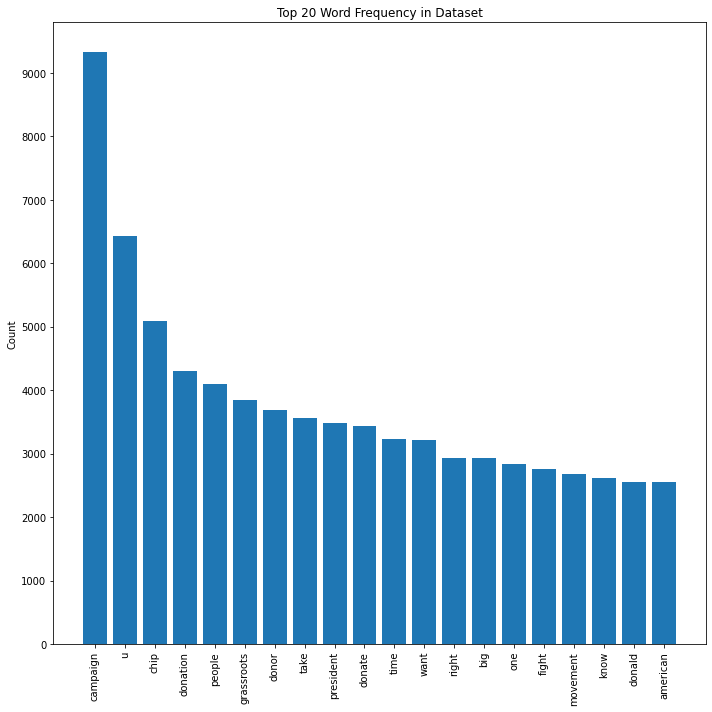

In [51]:
sample_freq_dist = FreqDist(finaldf["tokens"].explode())
visualize_top_20(sample_freq_dist, "Top 20 Word Frequency in Dataset")

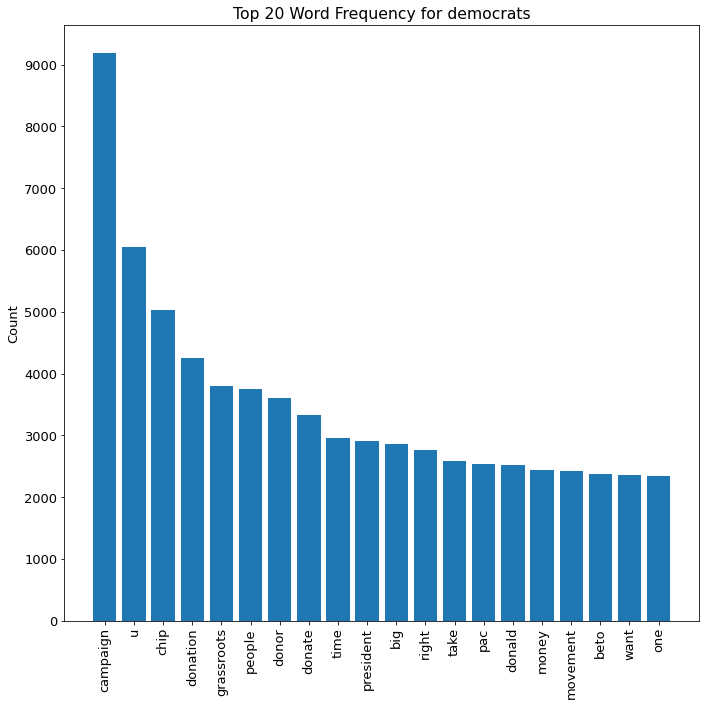

In [52]:
# Ten most common words appearing in democrat ads
sample_freq_dist = FreqDist(finaldf["tokens"].loc[finaldf['Party'] == 'Democrat'].explode())
visualize_top_20(sample_freq_dist, "Top 20 Word Frequency for democrats")

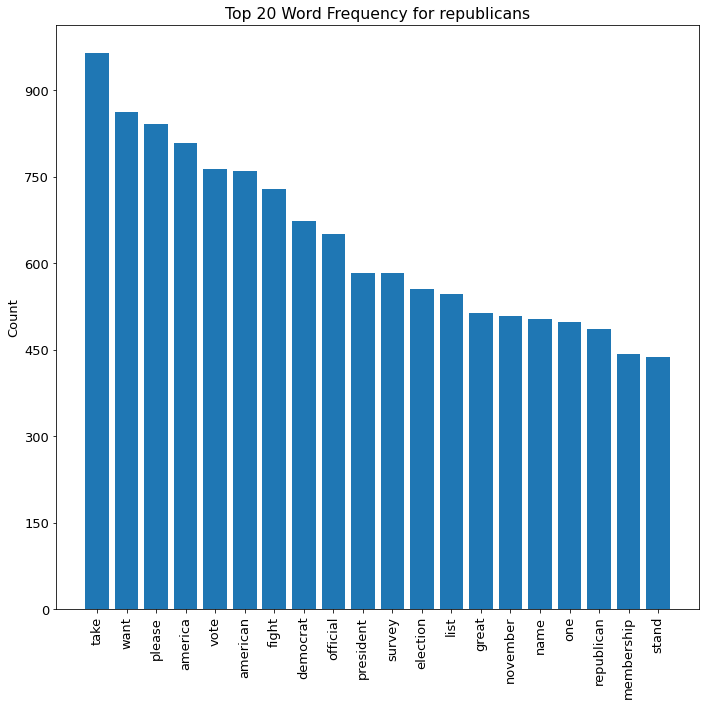

In [53]:
# Ten most common words appearing in Republican ads
sample_freq_dist = FreqDist(finaldf["tokens"].loc[finaldf['Party'] == 'Republican'].explode())
visualize_top_20(sample_freq_dist, "Top 20 Word Frequency for republicans")

In [54]:
demcol = get_single_color_func('deepskyblue')

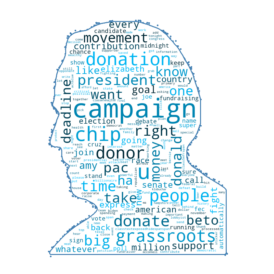

In [55]:
#create a mask for the word cloud shapes for democrats
maskdem = np.array(Image.open("../images/biden.jpg"))

# Create wordcloud for democratic ads for presentation
dem_word = finaldf["words"].loc[finaldf['Party'] == 'Democrat']
dem_text=" ".join(row for row in dem_word)
dem_freq = {}
for i in dem_text.split():
    if i in dem_freq:
        dem_freq[i] += 1
    else:
        dem_freq[i] = 1
dem_wordcloud = WordCloud(collocations=False, mask=maskdem, contour_width=2, contour_color='steelblue', background_color='white', width=1200, height=800).generate_from_frequencies(dem_freq)
plt.imshow(dem_wordcloud.recolor(color_func=demcol, random_state=5), interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

dem_wordcloud.to_file("../images/dem_cloud.png");

In [56]:
repcol = get_single_color_func('orangered')

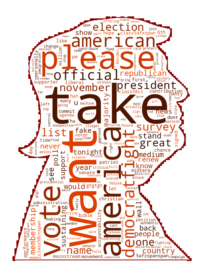

In [57]:
#create a mask for the word cloud shapes for democrats
maskrep = np.array(Image.open("../images/trump.jpg"))
# Create wordcloud for democratic ads for presentation
rep_word = finaldf["words"].loc[finaldf['Party'] == 'Republican']
rep_text=" ".join(row for row in rep_word)
rep_freq = {}
for i in rep_text.split():
    if i in rep_freq:
        rep_freq[i] += 1
    else:
        rep_freq[i] = 1
rep_wordcloud = WordCloud(collocations=False, mask=maskrep, contour_width=2, contour_color='darkred', background_color='white', width=1200, height=800).generate_from_frequencies(rep_freq)
plt.imshow(rep_wordcloud.recolor(color_func=repcol, random_state=1), interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

rep_wordcloud.to_file("../images/rep_cloud.png");

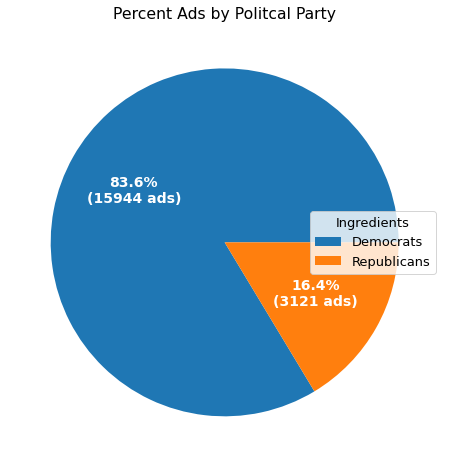

In [114]:
# Plot Target Class Distribution
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(aspect="equal"))

party = ["15944 Democrats",
          "3121 Republicans"]

data = [float(x.split()[0]) for x in party]
ingredients = [x.split()[-1] for x in party]


def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} ads)".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, ingredients,
          title="Ingredients",
          loc="right",)
plt.setp(autotexts, size=14, weight="bold")
ax.set_title("Percent Ads by Politcal Party")
plt.show()

In [120]:
justdem = finaldf[finaldf['Party'] != 'Republican']
demimp = justdem['impressions'].mean()
demimp

2.381209232313096

In [119]:
justrep = finaldf[finaldf['Party'] != 'Democrat']
repimp = justrep['impressions'].mean()
repimp

1.5908362704261454

# Modelling

### Train Test Split

In [58]:
# Specify X as the cleaned strings in finaldf['words'] and y as the party affiliation.
X = finaldf['words']
y = finaldf['Party']

In [59]:
#Performed the train-test split, using 30% for the hold-out data.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.30)

In [60]:
tfidf = TfidfVectorizer(max_features=None)
X_train_vectorized = tfidf.fit_transform(X_train)
X_train_vectorized

<13345x12089 sparse matrix of type '<class 'numpy.float64'>'
	with 365615 stored elements in Compressed Sparse Row format>

In [61]:
# Convert vectorized X_train to a vector for easier visual inspection.
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())
X_train_vec

,0br,0span,100year,10br,10sh,10th,1159pm,115th,116br,116th,...,zodiac,zombie,zondervan,zonesspan,zoo,zpr,zuckerberg,zuckerbergspan,él,éxito
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# Transform test data using TF-IDF Vectorizer trained on X_train, y_train
X_test_vectorized = tfidf.transform(X_test)
X_test_vectorized

<5720x12089 sparse matrix of type '<class 'numpy.float64'>'
	with 155688 stored elements in Compressed Sparse Row format>

In [63]:
# Convert to DataFrame for visual inspection
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=tfidf.get_feature_names())
X_test_vec

,0br,0span,100year,10br,10sh,10th,1159pm,115th,116br,116th,...,zodiac,zombie,zondervan,zonesspan,zoo,zpr,zuckerberg,zuckerbergspan,él,éxito
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Customer scorers using the weighted average argument, to be used in cross-validation

# Accuracy
accuracy = make_scorer(accuracy_score)

#f1
custom_f1 = make_scorer(
    f1_score, 
    average="weighted")

# Precision
multi_prec = make_scorer(
    precision_score,
    average="weighted")

# Recall
multi_rec = make_scorer(
    recall_score,
    average="weighted")

# This function will allow for quick cross-validation of the chosen score for each of our models.
def cross_val(model, X, y, custom_scorer, kfolds=5):
    """ Perform cross-validated scoring and store/print results """
    results = cross_val_score(model, X, y, cv=kfolds, scoring=custom_scorer)
    mean = np.mean(results)
    median = np.median(results)
    std = np.std(results)
    if custom_scorer == accuracy:
        print(f"Mean accuracy score: ", {mean}, ".")
        print(f"Median acuracy score: ", {median}, ".")
        print(f"Standard Deviation in accuracy: ", {std}, ".") 
    elif custom_scorer == custom_f1:
        print(f"Mean f1 score: ", {mean}, ".")
        print(f"Median f1 score: ", {median}, ".")
        print(f"Standard Deviation in f1 score: ", {std}, ".") 
    elif custom_scorer == multi_prec:
        print(f"Mean precision score: ", {mean}, ".")
        print(f"Median precision score: ", {median}, ".")
        print(f"Standard Deviation in precision score: ", {std}, ".") 
    elif custom_scorer == multi_rec:
        print(f"Mean recall score: ", {mean}, ".")
        print(f"Median recall score: ", {median}, ".")
        print(f"Standard Deviation in recall score: ", {std}, ".") 

## Dummy

In [65]:
# Instantiate Dummy Classifier pipeline
dummy_pipe = ImPipeline(steps=[
                                    ('vect', TfidfVectorizer(max_features=None)),
                                    ('sm', SMOTE(random_state=42)),
                                    ('dc', DummyClassifier(strategy="prior", random_state=42))
                                    ]
                            )

0.837542150618209


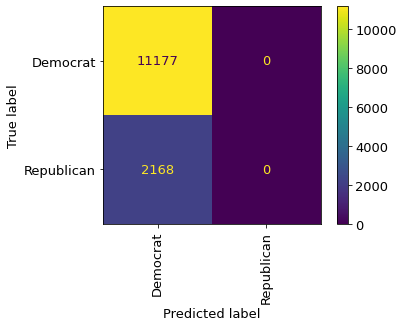

In [66]:
# Fit dummy pipe on the training data, get predictions and plot confusion matrix
dummy_pipe.fit(X_train, y_train)
dummy_yhat = dummy_pipe.predict(X_train)
plot_confusion_matrix(dummy_pipe, X_train, y_train, xticks_rotation=90);
print(accuracy_score(y_train, dummy_yhat))

## Multinomial Naive Bayes

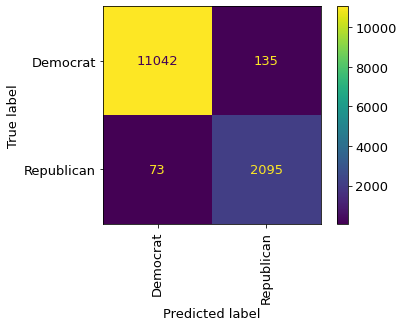

In [67]:
# Instantiate the MNB Pipeline
mnb_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=None)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('mnb', MultinomialNB())
                                ]
                        )

# Fit Multinomial Naive Bayes pipe on the training data, get predictions and plot confusion matrix
mnb_pipe.fit(X_train, y_train)
mnb_y_hat = mnb_pipe.predict(X_train)
plot_confusion_matrix(mnb_pipe, X_train, y_train, xticks_rotation=90);

In [68]:
# Show Classification Report
print(classification_report(y_train, mnb_y_hat))

              precision    recall  f1-score   support

    Democrat       0.99      0.99      0.99     11177
  Republican       0.94      0.97      0.95      2168

    accuracy                           0.98     13345
   macro avg       0.97      0.98      0.97     13345
weighted avg       0.98      0.98      0.98     13345



In [69]:
# Obtained cross-validated accuracy score
cross_val(mnb_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.975796178343949} .
Median acuracy score:  {0.9760209816410641} .
Standard Deviation in accuracy:  {0.0024580321419043405} .


## Logistic Regression

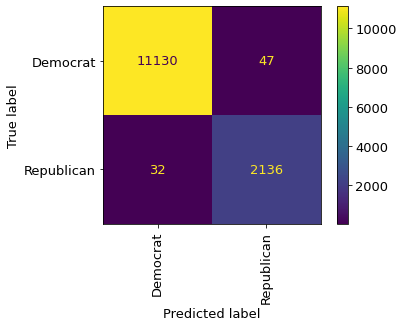

In [70]:
# Instantiate the Logistic Regression Pipeline
logreg_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=None)),
                                  ('sm', SMOTE(random_state=42)),
                                 ('lr', LogisticRegression(max_iter=1000))
                                ]
                        )

# Fit Logistic Regression pipeline on the training data, get predictions and plot confusion matrix
logreg_pipe.fit(X_train, y_train)
logreg_yhat = logreg_pipe.predict(X_train)
plot_confusion_matrix(logreg_pipe, X_train, y_train, xticks_rotation=90);

In [71]:
# Show Classification Report
print(classification_report(y_train, logreg_yhat))

              precision    recall  f1-score   support

    Democrat       1.00      1.00      1.00     11177
  Republican       0.98      0.99      0.98      2168

    accuracy                           0.99     13345
   macro avg       0.99      0.99      0.99     13345
weighted avg       0.99      0.99      0.99     13345



In [72]:
# Obtained cross-validated accuracy score
cross_val(logreg_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.9835893593106032} .
Median acuracy score:  {0.9838890970400899} .
Standard Deviation in accuracy:  {0.0008344345242157849} .


## Linear Support Vector

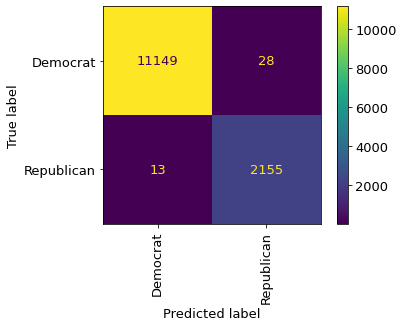

In [73]:
# Instantiate Linear Support Vector Pipeline
lsv_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=None)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('lsv', SGDClassifier(random_state=42))
                                ]
                        )

# Fit linear support vector machine on the training data, get predictions and plot confusion matrix
lsv_pipe.fit(X_train, y_train)
lsv_y_hat = lsv_pipe.predict(X_train)
plot_confusion_matrix(lsv_pipe, X_train, y_train, xticks_rotation=90);

In [74]:
# Show Classification Report
print(classification_report(y_train, lsv_y_hat))

              precision    recall  f1-score   support

    Democrat       1.00      1.00      1.00     11177
  Republican       0.99      0.99      0.99      2168

    accuracy                           1.00     13345
   macro avg       0.99      1.00      0.99     13345
weighted avg       1.00      1.00      1.00     13345



In [75]:
# Obtained cross-validated accuracy score
cross_val(lsv_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.986661671037842} .
Median acuracy score:  {0.9868864743349569} .
Standard Deviation in accuracy:  {0.0018139705413128748} .


## K-Nearest Neighbors

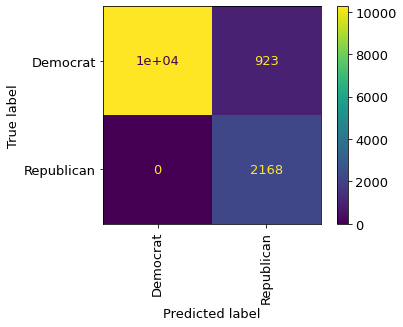

In [76]:
# Instantiate K-Nearest Neighbors pipeline
knn_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=None)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('knn', KNeighborsClassifier())  
                                ]
                        )

# Fit KNN pipeline on the training data, get predictions and plot confusion matrix
knn_pipe.fit(X_train, y_train)
knn_yhat = knn_pipe.predict(X_train)
plot_confusion_matrix(knn_pipe, X_train, y_train, xticks_rotation=90);

In [77]:
# Show Classification Report
print(classification_report(y_train, lsv_y_hat))

              precision    recall  f1-score   support

    Democrat       1.00      1.00      1.00     11177
  Republican       0.99      0.99      0.99      2168

    accuracy                           1.00     13345
   macro avg       0.99      1.00      0.99     13345
weighted avg       1.00      1.00      1.00     13345



In [78]:
# Obtained cross-validated accuracy score
cross_val(knn_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.8862495316597977} .
Median acuracy score:  {0.8849756463094792} .
Standard Deviation in accuracy:  {0.0063522126496883425} .


## Gradient Boosting Classifier

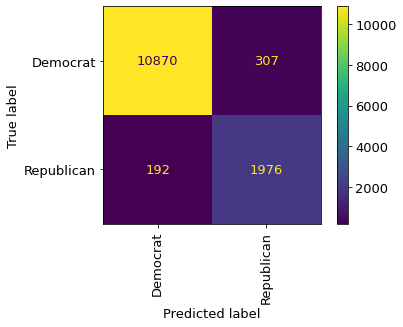

In [79]:
# Instantiate the pipeline
gbc_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=None)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('gbc',  GradientBoostingClassifier())
                                ]
                        )

# Fit gradient boosted pipeline on the training data, get predictions and plot confusion matrix
gbc_pipe.fit(X_train, y_train)
gbc_yhat = gbc_pipe.predict(X_train)
plot_confusion_matrix(gbc_pipe, X_train, y_train, xticks_rotation=90);

In [80]:
# Show Classification Report
print(classification_report(y_train, gbc_yhat))

              precision    recall  f1-score   support

    Democrat       0.98      0.97      0.98     11177
  Republican       0.87      0.91      0.89      2168

    accuracy                           0.96     13345
   macro avg       0.92      0.94      0.93     13345
weighted avg       0.96      0.96      0.96     13345



In [81]:
# Obtained cross-validated accuracy score
cross_val(gbc_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.947246159610341} .
Median acuracy score:  {0.9486699138254028} .
Standard Deviation in accuracy:  {0.006171977604188513} .


## RF Classifier

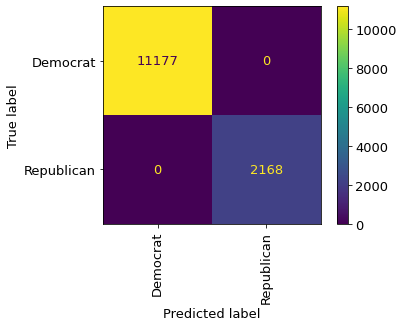

In [82]:
# Instantiate Random Forest pipeline
rf_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=None)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('rf', RandomForestClassifier(random_state=42))
                                ]
                        )

# Fit random forest pipeline on the training data, get predictions and plot confusion matrix
rf_pipe.fit(X_train, y_train)
rfp_yhat = rf_pipe.predict(X_train)
plot_confusion_matrix(rf_pipe, X_train, y_train, xticks_rotation=90);

In [83]:
# Show Classification Report
print(classification_report(y_train, rfp_yhat))

              precision    recall  f1-score   support

    Democrat       1.00      1.00      1.00     11177
  Republican       1.00      1.00      1.00      2168

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345



In [84]:
# Obtained cross-validated accuracy score
cross_val(rf_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.9828400149868864} .
Median acuracy score:  {0.9838890970400899} .
Standard Deviation in accuracy:  {0.001747756281707077} .


## Stochastic Gradient Descent Classifier

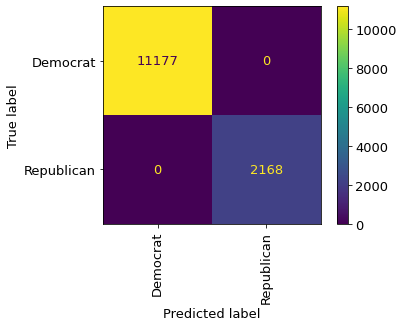

In [94]:
# Instantiate Linear Support Vector Pipeline
sgd_pipe = ImPipeline(steps=[    
                            ('vect', TfidfVectorizer(max_features=None, 
                                                #max_df= 0.5, messing with the min/maxdf seemed to only make the model perform worse
                                                #min_df= 0.1, 
                                                ngram_range= (1, 2))),
                            ('sm', SMOTE(random_state=42)),
                                ('sgd', SGDClassifier(random_state=42))
                                 ]
                                )
# Fit linear support vector machine on the training data, get predictions and plot confusion matrix
sgd_pipe.fit(X_train, y_train)
sgd_y_hat = sgd_pipe.predict(X_train)
plot_confusion_matrix(sgd_pipe, X_train, y_train, xticks_rotation=90);

In [95]:
# Show Classification Report
print(classification_report(y_train, sgd_y_hat))

              precision    recall  f1-score   support

    Democrat       1.00      1.00      1.00     11177
  Republican       1.00      1.00      1.00      2168

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345



In [96]:
# Obtained cross-validated accuracy score
cross_val(sgd_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.9877107530910452} .
Median acuracy score:  {0.988010490820532} .
Standard Deviation in accuracy:  {0.0010961962411635852} .


# Best Model Gridsearching

In [89]:
# Print out original parameters of rf classifier in rf_pipe
print('Current Parameters:\n')
pprint(sgd_pipe.named_steps['sgd'].get_params())

Current Parameters:

{'alpha': 1e-06,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'log_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'elasticnet',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [90]:
# Define new set of parameters to grid-search over
sgd_params = {
            'sgd__alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
            'sgd__learning_rate': ['optimal'],
            'sgd__loss': ['hinge', 'log_loss', 'modified_huber', 'perceptron', 'squared_error', 'huber'],
            'sgd__penalty': ['l2', 'l1', 'elasticnet'],
            'vect__ngram_range': [(1,2), (1,1), (2,2)],
            'vect__max_df': [0.5, 0.7, 0.9],
            'vect__min_df': [0.1, 0.3, 0.5],
            'vect__max_features': [None]
             }

# Instantiate grid search object using parameters defined above.
#sgd_gs = GridSearchCV(sgd_pipe, param_grid=sgd_params, n_jobs=1, verbose=3, cv=3)

# Fit the grid search object on training data
#sgd_gs.fit(X_train, y_train)

# Output the best parameters based on the grid search
#sgd_gs.best_params_

Fitting 3 folds for each of 2430 candidates, totalling 7290 fits
[CV 1/3] END sgd__alpha=1e-07, sgd__learning_rate=optimal, sgd__loss=hinge, sgd__penalty=l2, vect__max_df=0.5, vect__max_features=None, vect__min_df=0.1, vect__ngram_range=(1, 2);, score=0.708 total time=   0.5s
[CV 2/3] END sgd__alpha=1e-07, sgd__learning_rate=optimal, sgd__loss=hinge, sgd__penalty=l2, vect__max_df=0.5, vect__max_features=None, vect__min_df=0.1, vect__ngram_range=(1, 2);, score=0.778 total time=   0.6s
[CV 3/3] END sgd__alpha=1e-07, sgd__learning_rate=optimal, sgd__loss=hinge, sgd__penalty=l2, vect__max_df=0.5, vect__max_features=None, vect__min_df=0.1, vect__ngram_range=(1, 2);, score=0.717 total time=   0.6s
[CV 1/3] END sgd__alpha=1e-07, sgd__learning_rate=optimal, sgd__loss=hinge, sgd__penalty=l2, vect__max_df=0.5, vect__max_features=None, vect__min_df=0.1, vect__ngram_range=(1, 1);, score=0.708 total time=   0.3s
[CV 2/3] END sgd__alpha=1e-07, sgd__learning_rate=optimal, sgd__loss=hinge, sgd__penalt

KeyboardInterrupt: 

first gridsearch results: 
- sgd__alpha': 0.0001,
- sgd__early_stopping': True,
- sgd__learning_rate': 'optimal',
- sgd__loss': 'log_loss',
- sgd__penalty': 'l2',
- vect__strip_accents': 'ascii'

2nd gridsearch results:
- sgd__alpha': 0.0001,
- sgd__early_stopping': True,
- sgd__learning_rate': 'optimal',
- sgd__loss': 'modified_huber',
- sgd__penalty': 'l2',
- vect__strip_accents': 'ascii'}

3rd gridsearch results: this one performed much worse but guessing due to min/maxdf not being correct

- sgd__alpha: 1e-07,
- sgd__learning_rate: 'optimal',
- sgd__loss: 'perceptron',
- sgd__penalty: 'elasticnet',
- vect__max_df: 1,
- vect__max_features: None,
- vect__min_df: 0,
- vect__ngram_range: (2, 2)}

4th and final gridsearch results: potentially dont use min/maxdf for final model
- sgd__alpha': 1e-06,
- sgd__learning_rate': 'optimal',
- sgd__loss': 'log_loss',
- sgd__penalty': 'elasticnet',
- vect__max_df': 0.5,
- vect__max_features': None,
- vect__min_df': 0.1,
- vect__ngram_range': (1, 2)}

# Final model

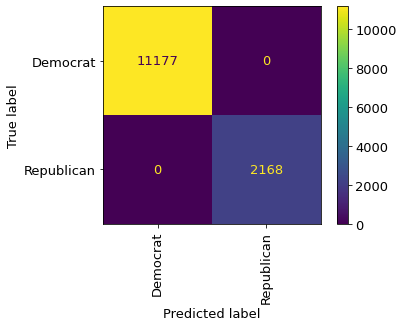

In [97]:
# Instantiate Linear Support Vector Pipeline
final_pipe = ImPipeline(steps=[    
                            ('vect', TfidfVectorizer(max_features=None, 
                                                #max_df= 0.5, messing with the min/maxdf seemed to only make the model perform worse
                                                #min_df= 0.1, 
                                                ngram_range= (1, 2))),
                            ('sm', SMOTE(random_state=42)),
                                ('sgd', SGDClassifier(random_state=42, 
                                                      alpha= 1e-06, 
                                                      learning_rate= 'optimal', 
                                                      loss = 'log_loss', 
                                                      penalty = 'elasticnet'))
                                 ]
                                )
# Fit linear support vector machine on the training data, get predictions and plot confusion matrix
final_pipe.fit(X_train, y_train)
final_y_hat = final_pipe.predict(X_train)
plot_confusion_matrix(final_pipe, X_train, y_train, xticks_rotation=90);

In [98]:
# Show Classification Report
print(classification_report(y_train, final_y_hat))

              precision    recall  f1-score   support

    Democrat       1.00      1.00      1.00     11177
  Republican       1.00      1.00      1.00      2168

    accuracy                           1.00     13345
   macro avg       1.00      1.00      1.00     13345
weighted avg       1.00      1.00      1.00     13345



In [99]:
# Obtained cross-validated accuracy score
cross_val(final_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.9877107530910452} .
Median acuracy score:  {0.988010490820532} .
Standard Deviation in accuracy:  {0.0010961962411635852} .


In [100]:
final_pipe.score(X_test, y_test)

0.9888111888111888